**MDPs And Basic RL Algoirhtms!** 

In this first notebook, we will look at Markov Decision Processes and some basic RL algorithms that can solve them! 
Some cells still need to be finished, leaving them as a challenge for you to solve! Some of these challenges are difficult, so don't worry if you get stuck. Answers are also available on a completed version of this notebook in the answers folder! Good luck! 

In [2]:
#Our imports
from Environments.maze import maze_game
import numpy as np
import scipy.signal
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from gymnasium import spaces

**The MDP**

A sensible first step when working on an RL problem, is taking a look at the Markov Decision Process (MDP) we are trying to solve (you can see the code for the env in Environments/maze.py). The observertion and action spaces describe the ins and outs of the MDP. An environment will expect inputs (actions) in the same format as its action_space. A policy will need to conform to these spaces, outputing actions that match the environments action_space, and accpet inputs in the form of the observation_space.

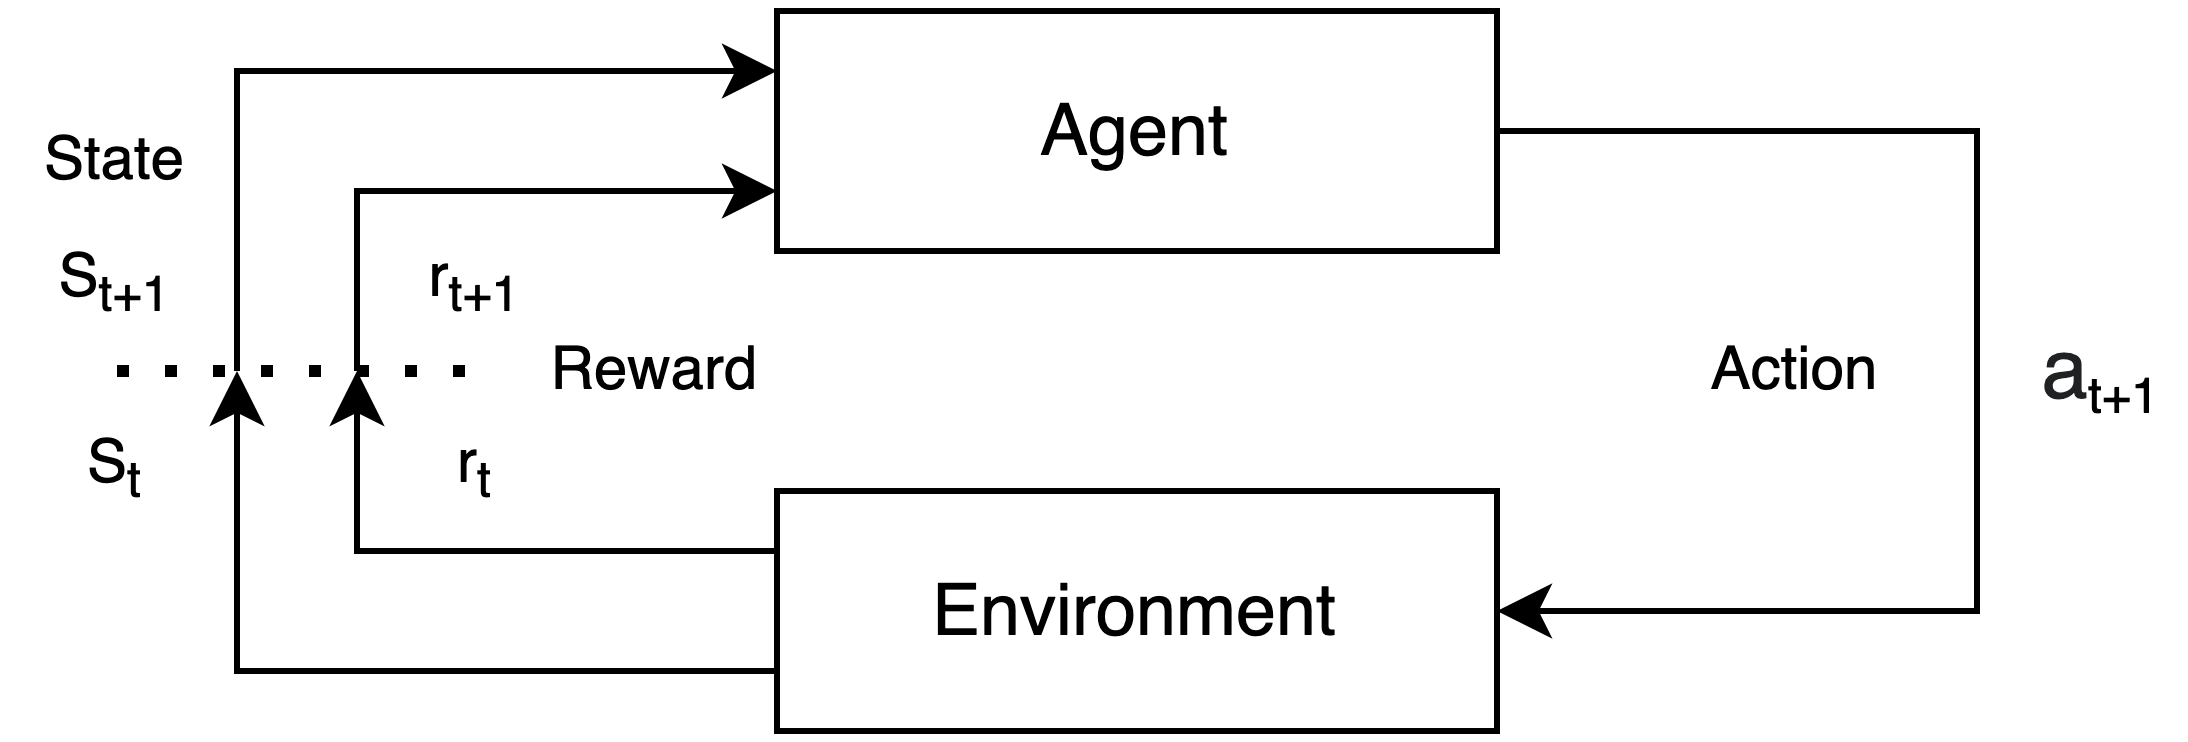

The MDP itself, typically called an 'environment' acts as a function that takes in an action and (considering its state) outputs a new state and a reward.

In [3]:
#Create an instance of the MDP we are going to solve
env = maze_game(difficulty='easy')
#Reset is a function MDPs use to reset the environment between episodes
env.reset()
print('Observation Space: ',  env.observation_space)
print('Action Space: ', env.action_space)
print(env.maze)

Observation Space:  Discrete(25)
Action Space:  Discrete(4)
[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


The problem we are looking at first is a simple maze game. The agent starts an episode at 'A', and needs to navigate to 'G'. When the agent arrives at 'G', the episode ends, and a possitive reward is given. The agent cannot pass through 'X'. 

Lets take a closer look at the spaces. The action space lets the agent move in 1 of the 4 cardinal directions, given by an integer. The 'Discrete' action space describes this. Discrete(4) allows interger actions in [0,4).

In [4]:
#.sample() can be used to see the action format expected by an environment
env.action_space.sample()

0

The observation space is Discrete(25) (integer actions in [0,25)). This is gives the policy the index of the grid square the agent is currently standing on. 

In [5]:
env.observation_space.sample()

14

We now have a better understanding of the environment we are trying to solve by looking at its expected inputs and outputs. 

**The Algorithms**

Now that we have an understanding of the MDP, we can implement some learning algorithms. Lets start with a value-based method 'Q-Learning'. We will stick to a tabular form for now, as it is easier to understand.   

Lets recall some of Q-Learning's notation:

$Q(s,a)$ is the value of taking action $a$ at state $s$ (the value of the state-action pair). If $Q(s,a)$ is optimal, the value is the discounted reward that is accumliated between taking $a$ at $s$ and the end of the episode (assuming a perfect policy is followed). We use the idea of discounted reward to weight the difference between short term and long term rewards. More on this later. In tabular Q-Learning $Q(s,a)$ is represented by a table of length equal to the number of states, and width equal to the number of actions. In the 'easy' maze problem, this would be a 25 by 4 matrix.

For now, lets condsider how actions are selected in tabular Q-Learning. We know that when we are at any $s$ in the maze, we have 4 actions availble to us. The optimal action will be the action that moves the agent closer to the goal, moving closer to goal moves the agent closer to reward, so the value of that action at $s$ will be greater than the other actions at $s$. So, to select an action, we take the argmax of $Q(s,a)$ at $s$; this is a 'greedy policy' (it always takes the best action). 

Typically, Q-Learning extends this basic 'greedy' policy by adding in random action selection. $\frac{\epsilon}{1}$ of the actions selected by an $\epsilon$-greedy policy will be random. Random action selection lets the agent explore paths it wouldn't choose otherwise. In code, we can write an $\epsilon$-greeedy policy as:

In [6]:
def epsilon_greedy_policy(state, q_table, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    return np.argmax(q_table[state])

So, we know how tabular Q-Learning selects actions using its Q-Table, but how does it optimise this Q-Table?

As well as being value-based, Q-Learning is also a temporal difference (TD) learner. TD is the value delta between 2 timesteps. 

If an agent takes $a$ in $s$ its state changes to $s'$. TD learning links the value of a state to the value of the next states it can transition to. So, some $Q(s,a)$'s value is linked to the future value $Q(s',a)$, this value is proportional of the discount factor $\gamma$. So to calculate the TD error, we talk about the difference between $Q(s,a)$ and discounted optimal value from $Q(s',a)$:  $\gamma \text{max}_{a}Q(s',a)$.

The TD error is only half of $Q(s,a)$ value, as we also need to consider the reward that is obtained by taking $a$ in $s$. Adding this in, we get the full update equation: 

$Q(s,a) \xleftarrow{} Q(s,a) + \alpha(r + \gamma \text{max}_{a}Q(s',a) - Q(s,a))$

The learning rate $\alpha$ is used here to limit the update size, RL updates are stochastic, so we need to take small steps to the solution (this is similar to supervised learning and is done for the same reason). 

To use this update equation, we conduct training episodes on the environment. An episode is a loop of action selection (from the policy), taking the action (in the environment), and then updating the q_table with state tranistion data. The psuldo-code for this is: 

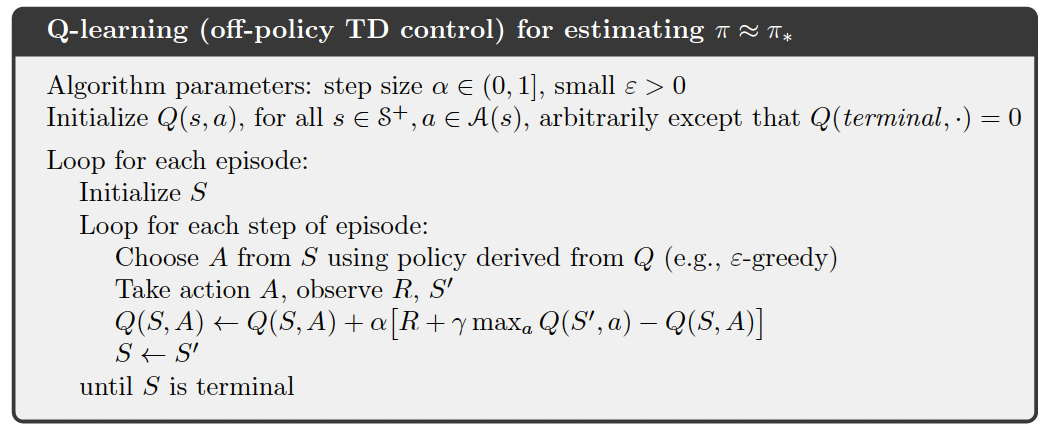

From: Reinforcemeant Learning: An Introduction

Turning this into code we get the cell below. Take your time to look over the class and comments.

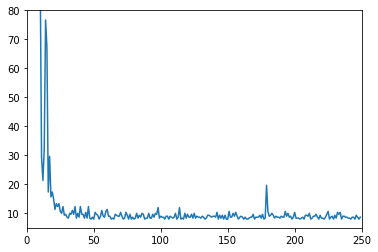

In [34]:
#Holding the Q Learning solver in a class for resuabilitiy.
#The environment is passed in and iterated over in 'solve'.
class QLearningSolver():

    def __init__(self, env, policy):
        #We randomly initialise the q_table so np.argmax(q_table[state]) can resolve, it 
        #also tends to solve faster than other initialisations.
        self.q_table = np.random.random((env.observation_space.n, env.action_space.n)) 
        #Learning Parameters
        self.lr = .1
        self.gamma = .98
        self.env = env
        self.epsilon = .1
        #Pass in the policy for action selection
        self.policy = policy

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            #Reset at the start of each episode. Reset gives us the inital environment state.
            state = maze_env.reset()['state']
            done = False
            while not done:
                #get an action from the policy
                action = self.policy(state, self.q_table, self.epsilon)
                #apply the action in the environment and get the update state from the env
                new_state, reward, done, _, _ = maze_env.step(action)
                #Q Learning update 
                self.q_table[state, action] += self.lr * (reward + self.gamma * np.max(self.q_table[new_state['state'], :]) - self.q_table[state, action])
                #Update the internal state
                state = new_state['state']
            steps.append(self.env.steps)
        return steps

#One result is meaningless. We need to repeat an experiment multiple times inorder to make conclusions.
num_trails = 3
num_episodes = 250
trails = []
for i in range(num_trails):
    #Crete the env, and run a trail
    maze_env = maze_game('easy')
    q_solver = QLearningSolver(maze_env, epsilon_greedy_policy)
    trails.append(q_solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

Hopefully you can see that Q-Learning could solve the maze problem! You should also notice that there is a fair bit of noise around the optimal step count (the shortest route through this maze is 8 steps). The noise is caused by the $\epsilon$-greedy policy.

**Challenge 1:**

After training, we need to evaluate the performance of a policy. This is done by running episodes on the target environment with all methods of exploration disabled. Modeify the code below to run an evaluation on the maze env with the Q-Learning solver. You should get an answer of 8 steps! (Notice that we don't run more that one evaluation episode here. Why?) 

In [40]:
step_counter = 0
state = q_solver.env.reset()
done = False
while not done:
    #get an action from the policy
    action = q_solver.policy(state['state'], q_solver.q_table, 0)
    #apply the action in the environment and get the update state from the env
    state, reward, done, _, _ = maze_env.step(action)
    step_counter += 1
print('Goal reached after ' + str(step_counter) + ' steps.')

Goal reached after 8 steps.


Now we are going to take a closer look at how Q-Learning is solving the Maze Problem. 

Recall that $V(s)$ is the value of a state. The value of a state is the average expected value from taking an action in $s$. By taking $V(s)$ at each state from the Q-Table, we can easily see how much it values each state in the maze.

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


<AxesSubplot:>

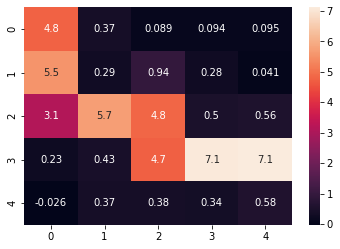

In [44]:
maze_env = maze_game('easy')
q_solver = QLearningSolver(maze_env, epsilon_greedy_policy)
q_solver.gamma = 0.99
q_solver.solve(num_episodes)
#Take the average value of each action at each state. 
state_values = np.mean(q_solver.q_table, axis=1)
state_values = state_values.reshape((int(np.sqrt(state_values.shape[0])),int(np.sqrt(state_values.shape[0]))))
print(env.maze)
sns.heatmap(state_values, annot=True)

**Challenge 2:**

Lets play about with the hyperparameters of Q-Learning. See what happens when you change the valeus of $\gamma$ and $\epsilon$. See how the learning plot and this heatmap affected by changing parameters. 

<AxesSubplot:>

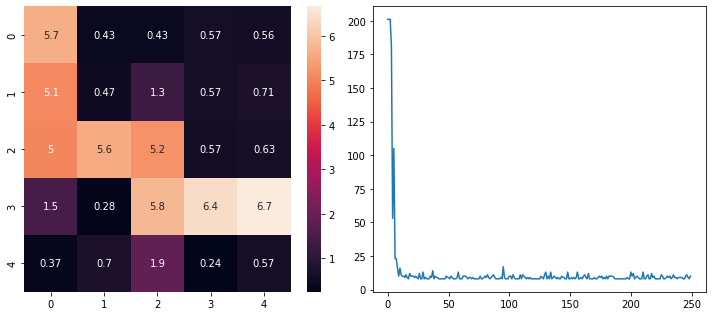

In [53]:
maze_env = maze_game('easy')
q_solver = QLearningSolver(maze_env, epsilon_greedy_policy)
#Change gamma and epsilon here!
q_solver.gamma = 0.99
q_solver.epsilon = 0.1
#solving
rewards = q_solver.solve(num_episodes)
#Take the average value of each action at each state. 
state_values = np.mean(q_solver.q_table, axis=1)
state_values = state_values.reshape((int(np.sqrt(state_values.shape[0])),int(np.sqrt(state_values.shape[0]))))
#plotting
plt.rcParams["figure.figsize"] = [10.00, 4.50]
f, axes = plt.subplots(1, 2)
sns.heatmap(state_values, annot=True, ax=axes[0])
sns.lineplot(rewards, ax=axes[1])

**Policy Gradient Methods**

The second class of algorithms we will look at are called 'Policy Gradient(PG) methods'. Policy gradent methods are different to value-based methods, like Q-Learning, because instead of estimating action values and then selecting actions based on those estimations, PG methods use a policy that is not linked to value estimates. Instead, a PG method learns by adjusting the weights of its policy with respect to an objective function (typically this is the expected return from following the policy through an epsiode). To do this, we need to be able to take the gradient of what ever policy we use with respect to it's parameters. The most simple way to do this is using a single weight layer, taking the softmax of the output to create the policy. As the maze has 25 states, and 4 actions, the input length of our layer needs to be 25, with an output of 4 (a 25 by 4 matrix).

This requirement from PG presents incompatibility with our current maze environment. A layer of weights needs to take a vector as input, so the single index observation space used for Q-Learning will not be compatible with our PG method. To make the maze environment compatible with PG, we produce a simple wrapper:

In [15]:
#A wrapper that converts the integer state space of the maze_game to a vector.
class one_hot_maze(maze_game):

    def __init__(self, difficulty):
        super().__init__(difficulty)
        #This wrapper updates the observation space. It is now best discribed a multibinary.
        self.observation_space = spaces.MultiBinary(self.maze.shape[0]**2)

    def step(self, action):
        state, reward, done, _, _ = super().step(action)
        state_onehot = np.zeros(self.observation_space.n)
        state_onehot[state['state']] = 1
        return {'state': state_onehot}, reward, done, None, None
    
    def reset(self):
        state = super().reset()
        state_onehot = np.zeros(self.observation_space.n)
        state_onehot[state['state']] = 1
        return {'state': state_onehot}

Wrappers (essentally just subclasses in OO programming lingo) let us make changes to an environment, without directly changing the environment code. Wrappers are common place in RL, as we usally don't want to make changes to an environments behaviour, we just want to add compatability between the environment and our learning algoithms. 

Now lets thing about the policy, it simply needs to be a pass through as single weight layer, with the softmax of the output (we take softmax as it produces a probability distribution over the outputs). We can do this in numpy with:

In [54]:
#policy that takes the state and a weight vector,
#returns an action and the softmax distribution over the actions
def softmax_policy(state, W):
    logits = np.dot(state['state'], W) #pass input through weight layer
    softmax = np.exp(logits) / sum(np.exp(logits)) #take softmax of the output
    action = np.random.choice(4, p=softmax) #weighted action selection
    return action, softmax

Now we have a policy, lets get back to breaking down the PG method:

PG methods are best understood through the policy gradient theorm, however, it is very maths dense, and takes a while to wrap your head around. For anyone who is interested, Chapter 13 of this book does a far better job of explaining it than I could: http://incompleteideas.net/book/the-book-2nd.html For the purpose of today, I will try to intuatively explain the resulting update equation. 

So, we have a policy that we can take the gradients from with respect to its parameters. We can think of this derivative as how responsible the weights are for each action probibility, the derivative is given by $\nabla$. When we combine derivatives produced by taking $a$ in $s$ with the probability of taking $a$, we produce something called the 'eligibility vector' ($\nabla log(\pi(s,a))$)*. The Eligibility Vector can be thought of as the direction we want to apply an update in policy weight space (given the action we selected). Now all we need to know is if we want to make the probability of taking $a$ in $s$ more or less likely. To do this, we multiply the eligibility vector by an estimate of the value of the state-action pair. This estimate is given by the observed gain from the state-action pair to the end of the episode: $G_t = \sum_{t}^{t\rightarrow T} \gamma^t r_t $ 
Basically the gain of the state-action pair is the discounted reward from then on in the episode. To calculate gain, PG methods have to be 'Monte-Carlo', meaning they can only apply an update after a rollout (and not during it like Q-Learning).

So, putting this together, we get an update equation for the weights of the policy (given by $\theta$):

$\theta = \theta - \alpha \nabla log(\pi(s_t,a_t)) G_t$

Now if we follow the algorithm for 'Reinforce' (the most simple episodic PG method), we can solve the maze environment with a PG method:

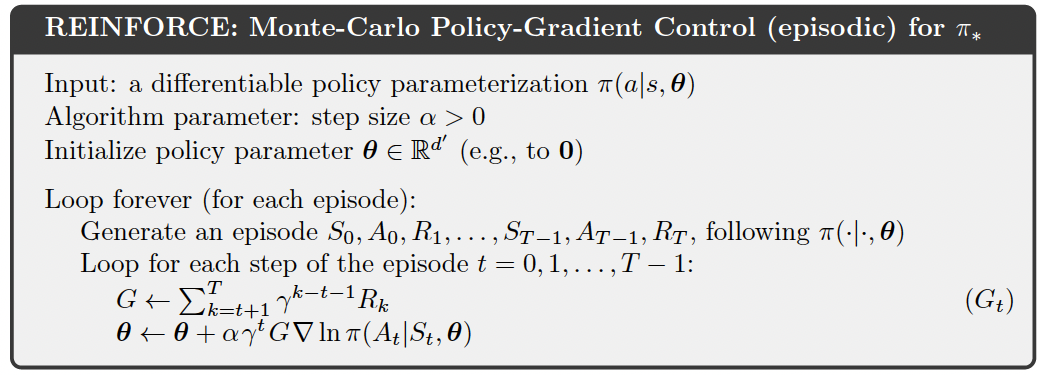

From: Reinforcemeant Learning: An Introduction

Turning this into code we get the cell below. Again, take your time to look over the class and comments.

*Notice that we actually take the log of the prob here. The log of a prob has a far greater dynamic range, so it is used as a surrogate to reduce errors that could be introduced by a lack of precision in floats. Feel free to modify the below to see what happens if you change the log (note, it isnt as simple as removing just the log). 

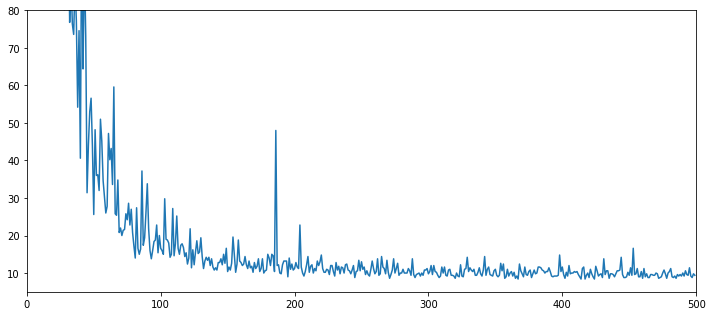

In [55]:
#Holding the PG solver in a class for resuabilitiy.
#The environment is passed in and iterated over in 'solve'.
class PolicyGradientSolver():

    def __init__(self, env, policy):
        #Create weight layer
        self.W = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.lr = .01
        self.gamma = .99
        self.policy = policy
        self.env = env

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            state = self.env.reset()
            #PG is a 'monte-carlo' method, it needs to store episodes before it can apply its update
            states = [state['state']]; rewards = []; actions = []; derivatives = []; probs_ = []
            done = False
            while not done:
                #Get action and probs from the policy
                action, probs = self.policy(state, self.W) 
                probs_.append(probs[action])
                #Take the derivative of the softmax with respect to the weights
                probs = np.expand_dims(probs, 1)
                jacobian = np.diagflat(probs) - np.dot(probs, probs.T)
                derivatives.append(jacobian[action])            
                actions.append(action)
                #Apply action in the environment
                new_state, reward, done, _, _ = self.env.step(action)
                states.append(new_state['state'])
                rewards.append(reward)
                state = new_state
            steps.append(self.env.steps)
            states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives); probs_ = np.array(probs_)
            #Calculate the discounted reward at each timestep in the episode
            gain = scipy.signal.lfilter([1], [1, float(-self.gamma)], np.array(rewards[::-1]), axis=0)[::-1]
            #We gather the update to take an average of the loss, this massively reduces variance in the update
            update = np.zeros((derivatives.shape[0], self.env.observation_space.n, 4))
            update[:,np.argmax(states[:-1],axis=1),:] = derivatives * np.log(probs_.reshape(-1,1)) * gain.reshape(-1,1) 
            self.W -= self.lr * update.mean(axis=0) 
        return steps

num_trails = 5
num_episodes = 500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('easy')
    pq_solver = PolicyGradientSolver(maze_env, softmax_policy)
    trails.append(pq_solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

We should see that the PG method has solved the Maze problem! But how has it done? Was it quicker than Q-Learning? 

Lets take a look at how the PG method learns. Unlike Q-Learning, we cannot look at its value estimate for each cell in the maze, instead, we can look at its policy entropy. The entropy across as state can the thought of as how certain the policy is in that state, lower values mean that the policy is more certain.

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


<AxesSubplot:>

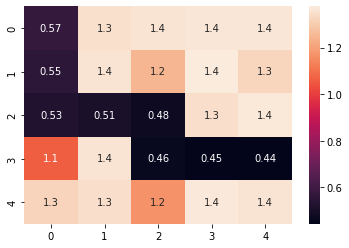

In [ ]:
entropy = []
for i in range(pq_solver.env.observation_space.n):
    state = {'state': np.zeros(pq_solver.env.observation_space.n)}
    state['state'][i] = 1
    action, softmax = pq_solver.policy(state, pq_solver.W)
    entropy.append(scipy.stats.entropy(softmax))
entropy = np.array(entropy).reshape(int(np.sqrt(pq_solver.env.observation_space.n)),int(np.sqrt(pq_solver.env.observation_space.n)))
print(env.maze)
sns.heatmap(entropy, annot=True)

Notice how the policy is more certain the closer it is to the reward. I'd recommend playing about with the hyperparameters again to see what effect it has on the learning. 

**Actor-Critic Methods**

Simple PG methods like the one above are rarely used in RL because they have a fundamental weakness. Stochastic rollouts produce a great deal of variance. This variance can make good actions appear bad if stochastic factors prevent the usual good reward obtained by selecting them to not occur. A way to make PG more resilient to variance is by using baselines to reduce the value of $G$. 

Note that not all AC methods are not all PG methods; however, these are the only AC methods we will consider here. 

By reducing the value of $G$, smaller updates will be produced that will change the policy less between episodes, improving stability. However, we don't want to reduce the size of an update if the policy has found a good improvement. Thankfully, a baseline has been found that can take care of this. 

'Advantage' is the difference between taking an action $a$ at state $s$ and the average value of taking an action at $s$: $A = Q(s,a) - V(s)$. Using advantage as a baseline makes sense because advantage gives positive values when the observed action is better than average. 

So, how do we calculate advantage while we are learning? You might recall that estimating $Q(s,a)$ is the goal of Q-Learning. Now, we could train a Q-Table to calculate advantage, but then we might as well just learn using Q-Learning. Instead, in 'Advantage Actor-Critic' we produce an estimate of advantage using observed data and a critic: $A_t \approx G_t - V(s_t)$. The critic is a separate function approximator that learns the values of the states (a far easier task than learning the value of state action pairs); combined with the actor (which, in this case, is the regular policy from the PG method), an Actor-Critic method is born. By subtracting the observed gain by the value estimate, we get an estimate for the quality of the action taken at $s$ in the rollout. 

Bring this advantage baseline into the update equation, we get: 

$\theta = \theta - \alpha \nabla log(\pi(s_t,a_t)) G_t - V(s_t)$

**Challenge 3:**

So, we have seen how a critic can be added to the PG method, its now time for implementation. Modify the code below to use the advantage actor-critic update. Note that a critic is already being trained for you.

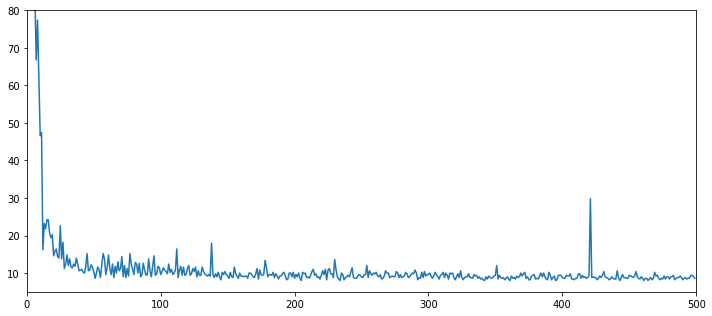

In [59]:
class PolicyGradientActorCriticSolver():

    def __init__(self, env, policy):
        self.W = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.V = np.random.random((env.observation_space.n, 1)) 
        self.lr = .1
        self.gamma = .97
        self.policy = policy
        self.env = env
        self.value_lr = .1
        self.value_lambda = 0.95

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            state = self.env.reset()
            rewards = []
            states = [state['state']]
            actions = []
            derivatives = []
            probs_ = []
            done = False
            while not done:
                action, probs = self.policy(state, self.W)
                probs_.append(probs[action])
                probs = np.expand_dims(probs, 1)
                jacobian = np.diagflat(probs) - np.dot(probs, probs.T)
                derivatives_ = jacobian[action]
                derivatives.append(derivatives_)
                actions.append(action)
                new_state, reward, done, _, _ = self.env.step(action)
                states.append(new_state['state'])
                rewards.append(reward)
                state = new_state
            steps.append(self.env.steps)
            states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives); probs_ = np.array(probs_)
            gain = scipy.signal.lfilter([1], [1, float(-self.gamma)], np.array(rewards[::-1]), axis=0)[::-1]
            update = np.zeros((derivatives.shape[0], self.env.observation_space.n, 4))
            update[:,np.argmax(states[:-1],axis=1),:] = derivatives * np.log(probs_.reshape(-1,1)) * (gain.reshape(-1,1) - np.dot(states[:-1], self.V))
            self.W -= self.lr * update.mean(axis=0) 
            
            #Simple gradient decent that takes advantage of the fact our state is one-hot
            update = np.zeros((states.shape[0]-1, self.env.observation_space.n, 1))
            update[:,np.argmax(states[:-1],axis=1),:] = (gain.reshape(-1,1) - np.dot(states[:-1], self.V))
            self.V += self.value_lr * update.mean(axis=0) 
            self.value_lr *= self.value_lambda
            
        return steps

num_trails = 5
num_episodes = 500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('easy')
    ac_solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy)
    trails.append(ac_solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

Hopefully you have seen much better performance from the AC method when compared with the PG method! 

Below are an entropy plot and a value estimate plot. Feel free to play about with them!

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


<AxesSubplot:>

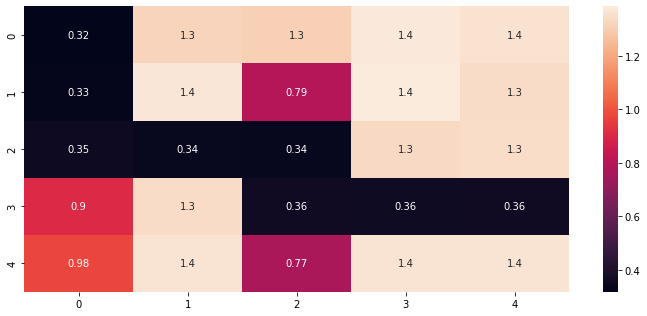

In [60]:
#Calcualte entropy on each cell
entropy = []
for i in range(ac_solver.env.observation_space.n):
    state = {'state': np.zeros(ac_solver.env.observation_space.n)}
    state['state'][i] = 1
    action, softmax = ac_solver.policy(state, ac_solver.W)
    entropy.append(scipy.stats.entropy(softmax))
entropy = np.array(entropy).reshape(int(np.sqrt(ac_solver.env.observation_space.n)),int(np.sqrt(ac_solver.env.observation_space.n)))
print(env.maze)
sns.heatmap(entropy, annot=True)

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


<AxesSubplot:>

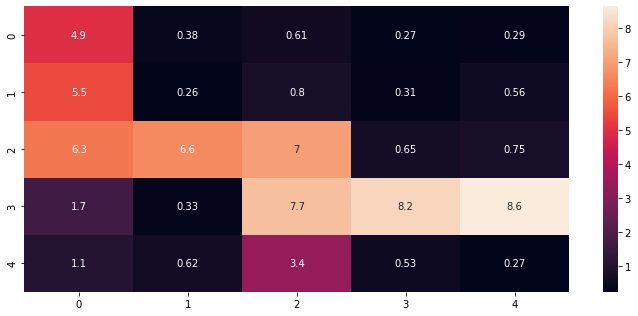

In [61]:
#Calcualte value on each cell
values = []
for i in range(ac_solver.env.observation_space.n):
    state = np.zeros(ac_solver.env.observation_space.n)
    state[i] = 1
    values.append(np.dot(state, ac_solver.V)[0])
values = np.array(values).reshape(int(np.sqrt(ac_solver.env.observation_space.n)),int(np.sqrt(ac_solver.env.observation_space.n)))
print(env.maze)
sns.heatmap(values, annot=True)

So in this section we have look at how 3 different algorithms can solve MDPs. We are now going to move on to a learning technique that can speed up learning.

**Action Masking**

Action masking lets an environment output a mask of all the valid actions give its current state. The action mask can then be used by an agent to prevent it from taking invalid actions. For example, in our maze environment, if the agent tries to walk into a wall, nothing will happen, so it would be valid and easy to mask out all actions that will not have an affect on the agents state.

Below is a wrapper for the one_hot_maze wrapper that adds an action_mask to the state:

In [67]:
class one_hot_maze_action_mask(one_hot_maze):

    def step(self, action):
        state, reward, done, _, _ = super().step(action)
        state['action_mask'] = self.get_action_mask()
        return state, reward, done, None, None
    
    def reset(self):
        state = super().reset()
        state['action_mask'] = self.get_action_mask()
        return state
    
    def get_action_mask(self):
        action_mask = np.zeros(4,dtype=np.int8)
        if self.y != 0:
            if self.maze[self.x, self.y-1] != 'X':
                action_mask[0] = 1
        if self.x != self.maze.shape[0]-1:
            if self.maze[self.x+1, self.y] != 'X':
                action_mask[1] = 1
        if self.y != self.maze.shape[1]-1:
            if self.maze[self.x, self.y+1] != 'X':
                action_mask[2] = 1
        if self.x != 0:
            if self.maze[self.x-1, self.y] != 'X':
                action_mask[3] = 1
        return action_mask

**Challenge 4** 

Now we need to change the softmax_policy to use the action mask. 'state['action_mask']' contains an matrix of the same shape as the logits, use it to prevent the policy from selecting an invalid action.

In [65]:
def softmax_policy_action_mask(state, W):
    logits = np.dot(state['state'], W)
    logits[state['action_mask']==0] = -1e8
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.random.choice(4, p=softmax)
    return action, softmax

If your action mask is working, we would expect a solver using to outperform a solver that isn't using action masking. You can use this code to check that:

<AxesSubplot:>

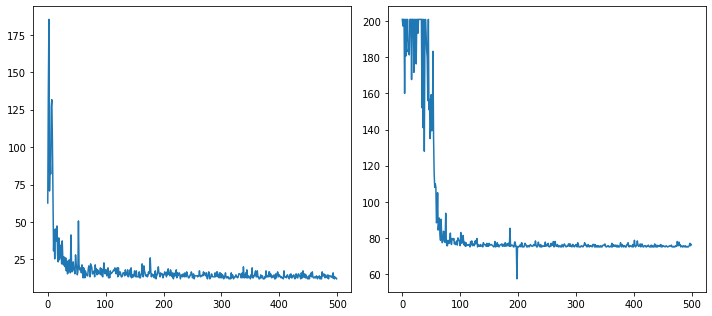

In [74]:
num_trails = 3
num_episodes = 500
difficulty = 'hard' #hard is a larger maze
trails_action_mask = []
trails_no_action_mask = []
for i in range(num_trails):
    maze_env = one_hot_maze_action_mask(difficulty)
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy_action_mask)
    solver.lr = 0.1
    trails_action_mask.append(solver.solve(num_episodes))

    maze_env = one_hot_maze_action_mask(difficulty)
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy)
    solver.lr = 0.1
    trails_no_action_mask.append(solver.solve(num_episodes))

f, axes = plt.subplots(1, 2)
sns.lineplot(np.array(trails_action_mask).mean(axis=0), ax=axes[0])
sns.lineplot(np.array(trails_no_action_mask).mean(axis=0), ax=axes[1])

**Challenge 5**

For the final challenge, modify the policy below to evaluate the solver using the action mask. 

In [82]:
def softmax_policy_action_mask_eval(state, W):
    logits = np.dot(state['state'], W)
    logits[state['action_mask']==0] = -1e8
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.argmax(softmax)
    return action, None

maze_env = one_hot_maze_action_mask('hard')
solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy_action_mask)
solver.lr = 0.1
trails_action_mask.append(solver.solve(num_episodes))

state = solver.env.reset()
solver.policy = softmax_policy_action_mask_eval
total_reward = 0
while not solver.env.done:
    action, probs = solver.policy(state, solver.W)
    new_state, reward, done, _, _ = solver.env.step(action)
    state = new_state
    total_reward += reward

print('Env steps: ', solver.env.steps)
print('Total Reward: ', total_reward)

Env steps:  12
Total Reward:  8.9


Assuming that the solver solves the maze, you should get: 

Env steps:  12; 
Total Reward:  8.9